In [120]:
import pandas as pd
import numpy as np
from pathlib import Path
import os 
from datetime import timedelta
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, accuracy_score, confusion_matrix, r2_score,log_loss
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn import tree
import graphviz

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier

pd.set_option('display.max_columns', None)
%matplotlib inline

data_path = str(Path(os.getcwd())) + "/data/"

def write_to_pickle(dataframe, name):
    dataframe.to_pickle(data_path + name + ".pickle")
def read_from_pickle(name): 
    return pd.read_pickle(data_path + name + ".pickle")


In [16]:
def plot_confusion_matrix(cm, classes=None, title='Confusion matrix', norm=False, **kwargs):
    """Plots a confusion matrix."""
    heatmap_kwargs = dict(annot=True, fmt='d')
    if norm:
        cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
        heatmap_kwargs['data'] = cm_norm
        heatmap_kwargs['vmin']=0.
        heatmap_kwargs['vmax']=1.
        heatmap_kwargs['fmt']='.3f'
    else:
        heatmap_kwargs['data'] = cm
    if classes is not None:
        heatmap_kwargs['xticklabels']=classes
        heatmap_kwargs['yticklabels']=classes
    heatmap_kwargs.update(kwargs)
    sns.heatmap(**heatmap_kwargs)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#cm = confusion_matrix(y_train, prediction_train)
#plt.figure()
#plot_confusion_matrix(cm, norm=True, classes=df_clean.life_expectancy_bin)
#plt.xlabel('Interpreted cluster label')
#plt.show()

In [2]:
df = read_from_pickle('preimputation')
df_imputed = pd.read_csv('data/final_dataset_analysis.csv')

In [3]:
df_small = df[['Gender', 'Tumor_grade', 'Gene_Idh1', 'Gene_Idh2','Tumor_Location',
       'Tumor_Position', 'Clinical_evolution', 'Surgery_type','Age_surgery', 'life_expectancy']]

#'ID_EC', 'IK_CLINIQUE', 'CHIR_IK_PRE', 'RX_IK_PRE', 'RX', 'CHEM'

In [4]:
df_final = df_imputed[['Gender', 'Tumor_grade', 'Gene_Idh1', 'Gene_Idh2','Tumor_Location',
       'Tumor_Position', 'Clinical_evolution', 'Surgery_type','Age_surgery', 'life_expectancy', 'Gene_Htert_C228T',
       'Gene_Htert_C250T', 'Gene_P53', 'Gene_Mgmt', 'Gene_Egfr', 'Gene_Mdm2',
       'Gene_Cdk4', 'Gene_P16', 'Gene_Ihc_Atrx', 'Gene_Ch1P', 'Gene_Ch19Q',
       'Gene_Ch10P', 'Gene_Ch10Q', 'Gene_Ch9P', 'Gene_Ch9Q', 'Tumor_Location',
       'Tumor_Position', 'Clinical_evolution', 'Surgery_type','Age_surgery', 'life_expectancy',
        'IDH_TERT', 'ID_EC', 'IK_CLINIQUE', 'CHIR_IK_PRE', 'RX_IK_PRE']]
df_final.head(2)

,Gender,Tumor_grade,Gene_Idh1,Gene_Idh2,Tumor_Location,Tumor_Position,Clinical_evolution,Surgery_type,Age_surgery,life_expectancy,Gene_Htert_C228T,Gene_Htert_C250T,Gene_P53,Gene_Mgmt,Gene_Egfr,Gene_Mdm2,Gene_Cdk4,Gene_P16,Gene_Ihc_Atrx,Gene_Ch1P,Gene_Ch19Q,Gene_Ch10P,Gene_Ch10Q,Gene_Ch9P,Gene_Ch9Q,Tumor_Location,Tumor_Position,Clinical_evolution,Surgery_type,Age_surgery,life_expectancy,IDH_TERT,ID_EC,IK_CLINIQUE,CHIR_IK_PRE,RX_IK_PRE
0,M,4,NC,NC,autre,G,P1,exérèse,60,268,NORMAL,ALTERE,NC,METHYLE,AMPLIFIE,AMPLIFIE,NORMAL,DELETE,Maintien,PERDU,PERDU,GAIN,GAIN,GAIN,PERDU,autre,G,P1,exérèse,60,268,4,P1,60,80,80
1,M,3,ALTERE,NORMAL,sus-T hémisp,G,TT ini,partielle,42,30,NORMAL,NORMAL,NC,METHYLE,NORMAL,NORMAL,NORMAL,NORMAL,Extinction diffuse,NON PERTE,NON PERTE,NON PERTE,PERDU,NON PERTE,NON PERTE,sus-T hémisp,G,TT ini,partielle,42,30,3,TTini,70,80,90


In [5]:
df_1 = df_small.dropna(axis=0, how='any')

In [ ]:
for col in df_1.columns:
    print('{0}\n  {1}\n'.format(col,df_1[col].isnull().value_counts()))

In [6]:
def binning(col, cut_points, labels=None):
    #Define min and max values:
    minval = col.min()
    maxval = col.max()

    #create list by adding min and max to cut_points
    break_points = [minval] + cut_points + [maxval]

    # if no labels provided, use default labels 0 ... (n-1)
    if not labels:
        labels = range(len(cut_points)+1)

    #Binning using cut function of pandas
    colBin = pd.cut(col,bins=break_points,labels=labels,include_lowest=True)
    return colBin


In [43]:
# Create bins so that we can cluster patients
#cut_points = [90,180,270,360,450,540,720,1095,1460,1825,3650]
labels = ["1.5year","4years","more"]
cut_points = [500,1500]
#labels = ["3_months","6_months","9_months","12_months","15_months","18_months","2_years","3_years","4_years","5_years","10_years","10_plus_years"]
df_1["life_expectancy_bin"] = binning(df_1.life_expectancy, cut_points, labels)
print(pd.value_counts(df_1.life_expectancy_bin, sort=False))

1.5year    794
4years     691
more       404
Name: life_expectancy_bin, dtype: int64


/Users/patricfulop/anaconda3/envs/cancer/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


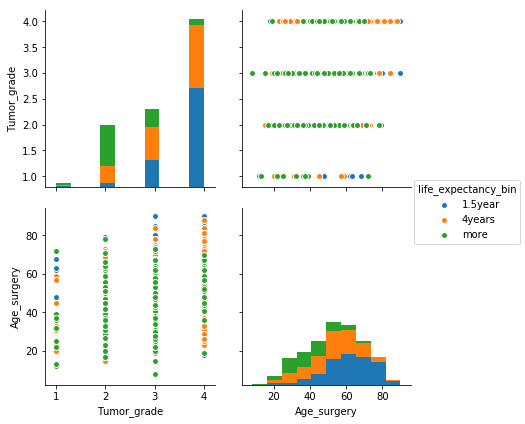

In [45]:
g = sns.pairplot(data=df_1,vars=['Tumor_grade','Age_surgery'],hue='life_expectancy_bin',size=3)

In [129]:
df_final.IK_CLINIQUE.value_counts()

90     633
80     592
70     421
60     287
100    174
40      42
50      36
75      11
20      11
0       11
Name: IK_CLINIQUE, dtype: int64

In [46]:
for column in df_1:
    unique_vals = np.unique(df_1[column])
    nr_vals = len(unique_vals)
    if nr_vals < 20:
        print('Number of values for attribute {}: {} -- {}'.format(column, nr_vals, unique_vals))
    else:
        print('Number of values for attribute {}: {}'.format(column, nr_vals))

Number of values for attribute Gender: 2 -- ['F' 'M']
Number of values for attribute Tumor_grade: 4 -- [ 1.  2.  3.  4.]
Number of values for attribute Gene_Idh1: 3 -- ['ALTERE' 'NC' 'NORMAL']
Number of values for attribute Gene_Idh2: 3 -- ['ALTERE' 'NC' 'NORMAL']
Number of values for attribute Tumor_Location: 11 -- ['Frontal' 'Rolandique' 'autre' 'cervelet' 'moelle/rachis' 'non précisé'
 'sus-T hémisp' 'sus-T hémisp+profond' 'sus-T profond' 'tronc cérébral'
 'ventriculaire']
Number of values for attribute Tumor_Position: 5 -- ['D' 'G' 'bilatéral' 'médian' 'non précisé']
Number of values for attribute Clinical_evolution: 4 -- ['P1' 'P2' 'P3' 'TT ini']
Number of values for attribute Surgery_type: 4 -- ['aucune' 'biopsie' 'exérèse' 'partielle']
Number of values for attribute Age_surgery: 78
Number of values for attribute life_expectancy: 1223
Number of values for attribute life_expectancy_bin: 3 -- ['1.5year' '4years' 'more']


Create a categorical encoding of the dataset

In [47]:
le_dict = dict() # Initialise an empty dictionary to keep all LabelEncoders
df_clean = df_1.copy(deep=True) # Make a copy of the DataFrame
# Loop over attributes by excluding the ones that are continuous and the target variable
for column in df_clean.drop(['Age_surgery', 'life_expectancy'], axis=1):  
    le = LabelEncoder().fit(df_1[column]) # Initialise the LabelEncoder and fit
    df_clean[column] = le.transform(df_1[column]) # Transform data and save in credit_clean DataFrame
    le_dict[column] = le # Store the LabelEncdoer in dictionary

We also need dummies. 
- Q: Should I standardize anything? Doesn't look like surgery age should be, but keep that in mind. 
- Q: What are the right methods for this kind of mixed dataset?

In [48]:
df_c = df_1.copy(deep=True)
df_clean_dummies = pd.get_dummies(df_c.drop(['life_expectancy',"life_expectancy_bin"],axis=1))


In [130]:
df_clean_dummies.head(2)

,Tumor_grade,Age_surgery,Gender_F,Gender_M,Gene_Idh1_ALTERE,Gene_Idh1_NC,Gene_Idh1_NORMAL,Gene_Idh2_ALTERE,Gene_Idh2_NC,Gene_Idh2_NORMAL,Tumor_Location_Frontal,Tumor_Location_Rolandique,Tumor_Location_autre,Tumor_Location_cervelet,Tumor_Location_moelle/rachis,Tumor_Location_non précisé,Tumor_Location_sus-T hémisp,Tumor_Location_sus-T hémisp+profond,Tumor_Location_sus-T profond,Tumor_Location_tronc cérébral,Tumor_Location_ventriculaire,Tumor_Position_D,Tumor_Position_G,Tumor_Position_bilatéral,Tumor_Position_médian,Tumor_Position_non précisé,Clinical_evolution_P1,Clinical_evolution_P2,Clinical_evolution_P3,Clinical_evolution_TT ini,Surgery_type_aucune,Surgery_type_biopsie,Surgery_type_exérèse,Surgery_type_partielle
0,4.0,60.0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0
1,3.0,42.0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1


In [49]:
df_clean.head(2)
#df_clean_dummies.head(2)

,Gender,Tumor_grade,Gene_Idh1,Gene_Idh2,Tumor_Location,Tumor_Position,Clinical_evolution,Surgery_type,Age_surgery,life_expectancy,life_expectancy_bin
0,1,3,1,1,2,1,0,2,60.0,268.0,0
1,1,2,0,2,6,1,3,3,42.0,30.0,0


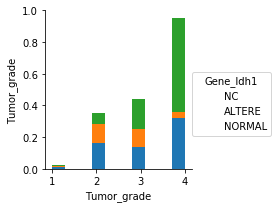

In [131]:
g = sns.pairplot(data=df_1,vars=['Tumor_grade'],hue='Gene_Idh1',size=3)

In [50]:
X_train, X_test, y_train, y_test = train_test_split(df_clean.drop(["life_expectancy","life_expectancy_bin"], axis=1), df_clean.life_expectancy_bin,
                                                    train_size=0.8, test_size=0.2, random_state=1)
#X_train.describe(include=['O'])
#X_train.describe(include=[np.number])
X_train_dummies, X_test_dummies, y_train_dummies, y_test_dummies = train_test_split(df_clean_dummies, df_clean.life_expectancy_bin,
                                                   train_size=0.8, test_size=0.2, random_state=1)

X_train_dummies.head(2)


,Tumor_grade,Age_surgery,Gender_F,Gender_M,Gene_Idh1_ALTERE,Gene_Idh1_NC,Gene_Idh1_NORMAL,Gene_Idh2_ALTERE,Gene_Idh2_NC,Gene_Idh2_NORMAL,Tumor_Location_Frontal,Tumor_Location_Rolandique,Tumor_Location_autre,Tumor_Location_cervelet,Tumor_Location_moelle/rachis,Tumor_Location_non précisé,Tumor_Location_sus-T hémisp,Tumor_Location_sus-T hémisp+profond,Tumor_Location_sus-T profond,Tumor_Location_tronc cérébral,Tumor_Location_ventriculaire,Tumor_Position_D,Tumor_Position_G,Tumor_Position_bilatéral,Tumor_Position_médian,Tumor_Position_non précisé,Clinical_evolution_P1,Clinical_evolution_P2,Clinical_evolution_P3,Clinical_evolution_TT ini,Surgery_type_aucune,Surgery_type_biopsie,Surgery_type_exérèse,Surgery_type_partielle
408,4.0,79.0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0
1352,2.0,32.0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0


# We move forward with two encodings, dummies and categorical

Now apply PCA to lower the dimensionality of our data. And then perform a simple classification using a Decision Tree or K-means. Next Random Forests and then Regression with some polynomial function.

In [ ]:
X_train.describe(include=[np.number])

# PCA on dummies or categorical data doesn't work
I suspect it has to do with the continous variables being there too. Otherwise it should totally catch what's happening no? 

In [132]:
dt = DecisionTreeClassifier(criterion='entropy', max_depth=6,random_state=1500)
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1500,
            splitter='best')

In [116]:
dot_data = tree.export_graphviz(dt, out_file=None, 
    feature_names= df_clean.drop(["life_expectancy_bin","life_expectancy"], axis=1).columns,  
    class_names = labels,  
    filled=True, rounded=True,  
    special_characters=True)
graph = graphviz.Source(dot_data)
graph
#To create a file do this:
#To create a file do this:
with open("tree.dot", 'w') as f:
     f = export_graphviz(dt, out_file=f,
                         feature_names = df_clean.drop(["life_expectancy_bin","life_expectancy"], axis=1).columns,  
                         class_names = labels,   
                         filled=True, rounded=True,  
                         special_characters=True)

In [133]:
prediction_train = dt.predict(X=X_train)
prediction_test = dt.predict(X=X_test)
print('Classification accuracy on training set: {:.3f}'.format(accuracy_score(y_train,prediction_train)))
print('Classification accuracy on test set: {:.3f}'.format(accuracy_score(y_test,prediction_test)))

Classification accuracy on training set: 0.664
Classification accuracy on test set: 0.614


Random Forests

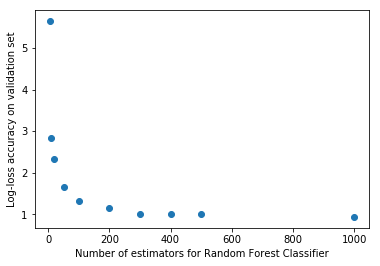

Optimal number of estimators based on validation set: 1000
Log-loss accuracy on validation set: 0.927


In [123]:
# Decide RF n_estimators based on validation set
estimators_range = [5, 10, 20, 50, 100, 200, 300, 400, 500, 1000]
validation_accuracy = []
for n_estimators in estimators_range:
    rfc_b = RandomForestClassifier(criterion='entropy', 
                                   n_estimators=n_estimators,
                                   max_features = 3,
                                   n_jobs = -1,
                                   random_state = 31)
    rfc_b.fit(X_train, y_train)
    validation_accuracy.append(log_loss(y_test, rfc_b.predict_proba(X_test)))
n_estimators_optimal = estimators_range[np.argmin(validation_accuracy)]
plt.figure()
plt.scatter(estimators_range, validation_accuracy)
plt.ylabel('Log-loss accuracy on validation set')
plt.xlabel('Number of estimators for Random Forest Classifier')
plt.show()
print('Optimal number of estimators based on validation set: {}\nLog-loss accuracy on validation set: {:.3f}'.
    format(n_estimators_optimal, validation_accuracy[np.argmin(validation_accuracy)]))   

# Not so relevant below here 

In [ ]:
rs = {}
n_components = [1,2,3,4,5,6,7]
#n_components = [1,2,3,5,10,20,30]
for nc in n_components:
    reduced_data = PCA(n_components=nc).fit_transform(X_train)
    kmeans_pca = KMeans(n_clusters=12, random_state=1337)
    kmeans_pca.fit(reduced_data)
    rs[nc] = adjusted_rand_score(y_train, kmeans_pca.labels_)
    print('nc={}, inertia={}, randscore={}'.format(nc, kmeans_pca.inertia_, rs[nc]))


pca_dummies = PCA(n_components = 4)
pca_dummies.fit(X_train_dummies)
plt.figure()
plt.plot(np.arange(1,pca_dummies.explained_variance_ratio_.size + 1), pca_dummies.explained_variance_ratio_)
plt.xlabel('n_components')
plt.ylabel('explained_variance_ratio_')
n_eigenvectors_95pc = np.argmax(np.cumsum(pca_dummies.explained_variance_ratio_) > .95) + 1
max_variance = np.max(pca_dummies.explained_variance_ratio_)
plt.vlines(x = n_eigenvectors_95pc, ymin=0, ymax=max_variance, linestyle='--')
plt.annotate('95% variance explained\nby {} eigenvectors'.format(n_eigenvectors_95pc), 
             xy=(n_eigenvectors_95pc, pca_dummies.explained_variance_ratio_[n_eigenvectors_95pc]), 
             xytext=(n_eigenvectors_95pc+10, pca_dummies.explained_variance_ratio_[n_eigenvectors_95pc]+.05),
             arrowprops=dict(facecolor='black', shrink=0.05),)
plt.margins(0.1, tight=True)
plt.show()

In [54]:
# Question is how many components do you train it with. 
# that's why you plot the variance ratio first to see where you have 95%
pca = PCA(n_components = 4)
X_train_pca = pca.fit_transform(X_train)

# Here we can change it and add the decision tree if we want. 
classifier = DecisionTreeClassifier(criterion='entropy',max_depth =5,random_state=1337)

# Use Cross Validation to determine the good parameteres
n_folds = 5
cv = KFold(n_splits=n_folds, shuffle=True, random_state=1000)

# 1 since we have only one classifier - for now
score_array = np.zeros((1, cv.n_splits))
print(score_array.shape)


for i, (train_idx, valid_idx) in enumerate(cv.split(X_train_pca)):
        X_tr = X_train_pca[train_idx,:]
        X_val = X_train_pca[valid_idx,:]
        
        le = LabelEncoder()
        y_le = le.fit_transform(y_train)
        y_tr = y_le[train_idx]
        y_val = y_le[valid_idx]
        classifier.fit(X_tr,y_tr)
        score_array[:,i] = classifier.score(X_val, y_val)
        
print('Mean Accuracy: ' + str(np.mean(score_array))+ " Standard Error: "+ str(np.std(score_array)/np.sqrt(n_folds)))
#print(pd.DataFrame.from_dict(
 #       {'Model': labels, 
#        'Mean Accuracy':np.mean(score_array), 
  #       'Standard Error':np.std(score_array)/np.sqrt(n_folds)
##      })[['Model', 'Mean Accuracy', 'Standard Error']])

(1, 5)
Mean Accuracy: 0.537409568771 Standard Error: 0.0150285943667


In [ ]:
# Question is how many components do you train it with. 
# that's why you plot the variance ratio first to see where you have 95%
pca = PCA(n_components = X_train.shape[1])
X_train_pca = pca.fit_transform(X_train)

# Here we can change it and add the decision tree if we want. 
clfs = [GaussianNB(), DecisionTreeClassifier(criterion='entropy',max_depth =3,random_state=1337)]

# doesn't make sense to use GNB
labels = ['GNB','DecisionTreeClassifier']
data = [X_train, X_train_pca]
n_folds = 5
cv = KFold(n_splits=n_folds, shuffle=True, random_state=1337)

score_array = np.zeros((len(clfs), cv.n_splits))

for ii, clf in enumerate(clfs):
    for jj, (train_idx, valid_idx) in enumerate(cv.split(data[ii])):
        X_tr = data[ii][train_idx,:]
        X_val = data[ii][valid_idx,:]
        y_tr = y_train[train_idx]
        y_val = y_train[valid_idx]
        clf.fit(X_tr,y_tr)
        score_array[ii,jj] = clf.score(X_val, y_val)

        
print(pd.DataFrame.from_dict(
        {'Model': labels, 
         'Mean Accuracy':np.mean(score_array,axis=1), 
         'Standard Error':np.std(score_array,axis=1)/np.sqrt(n_folds)
        })[['Model', 'Mean Accuracy', 'Standard Error']])

plt.figure()        
plt.errorbar(range(len(clfs)), 
            np.mean(score_array,axis=1), 
            yerr=np.std(score_array,axis=1)/np.sqrt(n_folds), 
            fmt='o')
plt.xticks(range(len(clfs)), labels, rotation='vertical')
plt.title('Model comparison')
plt.margins(0.1, tight=True)
plt.show()